## Install libraries

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Dataset loading and preparation

In [2]:
original_dir = '/kaggle/input/original-and-retouched-faces-images-dataset/original'
retouched_dir = '/kaggle/input/original-and-retouched-faces-images-dataset/retouched'

num_images_to_load = 1000  # Set number of images to use in dataset
batch_size = 4

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size: int = 512  # the generated image resolution
    train_batch_size: int = 32  # replace `batch_size` with an actual default value
    eval_batch_size: int = 32
    num_epochs: int = 50
    beta1: float = 0.5
    beta2: float = 0.999
    learning_rate: float = 1e-4
    res_layers: int = 10

# Now when you instantiate this dataclass, it will correctly create instance variables
config = TrainingConfig()
config

TrainingConfig(image_size=512, train_batch_size=32, eval_batch_size=32, num_epochs=50, beta1=0.5, beta2=0.999, learning_rate=0.0001, res_layers=10)

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, original_dir, retouched_dir, transform=None, num_images=None, split='train', val_ratio=0.1, test_ratio=0.1):
        self.original_dir = original_dir
        self.retouched_dir = retouched_dir
        self.transform = transform
        
        # Get list of image names and ensure the same images are in both folders
        self.original_images = sorted(os.listdir(original_dir))
        self.retouched_images = sorted(os.listdir(retouched_dir))
        self.original_images = [img for img in self.original_images if img in self.retouched_images]
        
        # Dynamically choose number of images to load
        if num_images is not None:
            self.original_images = self.original_images[:num_images]
        
        # Split the dataset into train, validation, and test sets
        train_images, test_images = train_test_split(self.original_images, test_size=test_ratio, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=val_ratio / (1 - test_ratio), random_state=42)

        if split == 'train':
            self.image_list = train_images
        elif split == 'val':
            self.image_list = val_images
        elif split == 'test':
            self.image_list = test_images
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        original_image_path = os.path.join(self.original_dir, self.image_list[idx])
        retouched_image_path = os.path.join(self.retouched_dir, self.image_list[idx])  # Same name

        original_image = Image.open(original_image_path).convert('RGB')
        retouched_image = Image.open(retouched_image_path).convert('RGB')
        
        if self.transform:
            original_image = self.transform(original_image)
            retouched_image = self.transform(retouched_image)
        
        return original_image, retouched_image

In [5]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = v2.Compose([
    v2.Resize((config.image_size, config.image_size)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std),
])

In [6]:
train_dataset = PairedImageDataset(original_dir,
                                   retouched_dir,
                                   transform=transform,
                                   num_images=num_images_to_load,
                                   split='train')
val_dataset = PairedImageDataset(original_dir,
                                 retouched_dir,
                                 transform=transform,
                                 num_images=num_images_to_load,
                                 split='val')
test_dataset = PairedImageDataset(original_dir,
                                  retouched_dir,
                                  transform=transform,
                                  num_images=num_images_to_load,
                                  split='test')

In [7]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [8]:
len(train_loader)

200

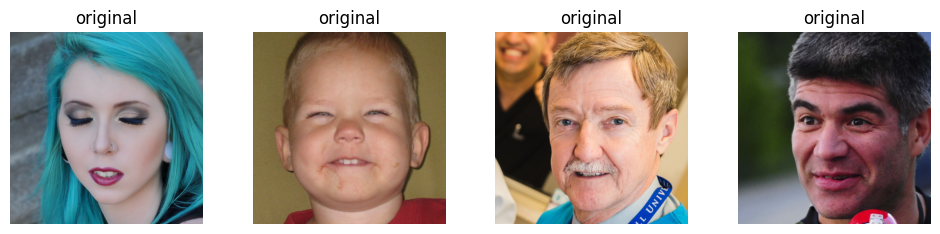

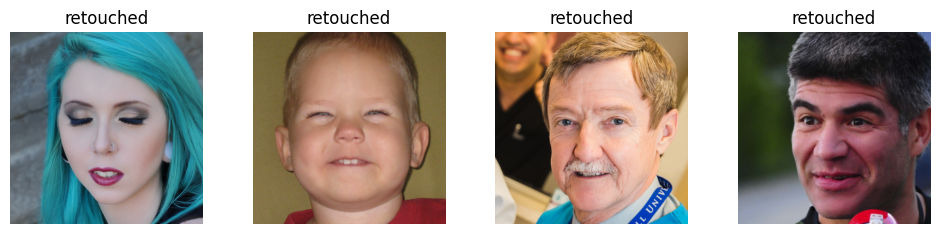

In [9]:
# Check that images loaded correctly

def imshow_batch(orig, retouch):
    orig = orig / 2 + 0.5
    orig = orig.numpy()

    batch_size = len(orig)
    _, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 2.5))
    if batch_size == 1: axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = np.transpose(orig[idx], (1, 2, 0))
        ax.imshow(img)
        ax.set_title("original")
        ax.axis('off')
    plt.show()
    
    retouch = retouch / 2 + 0.5
    retouch = retouch.numpy()
    
    batch_size = len(retouch)
    _, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 2.5))
    if batch_size == 1: axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = np.transpose(retouch[idx], (1, 2, 0))
        ax.imshow(img)
        ax.set_title("retouched")
        ax.axis('off')
    plt.show()


for images, labels in train_loader:
    imshow_batch(images, labels)
    break

In [10]:
! pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.1 MB/s eta 0:00:00


In [11]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [13]:
import wandb
wandb.login(key='861c264c6c09e0e26215f54bf483cf08cae0ee88')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self,n_residual = 15):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Added layer to match channels
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(128) for _ in range(n_residual)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.final = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x1 = self.initial(x)
        x2 = self.residual_blocks(x1)
        x3 = self.upsample(x2 + x1)
        return self.final(x3)

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
generator = Generator(n_residual=config.res_layers)
discriminator = PatchGANDiscriminator()

# Testing with dummy input
dummy_input = torch.randn(1, 3, 256, 256)
gen_output = generator(dummy_input)
disc_output = discriminator(gen_output)

print("Generator output shape:", gen_output.shape)
print("Discriminator output shape:", disc_output.shape)

Generator output shape: torch.Size([1, 3, 256, 256])
Discriminator output shape: torch.Size([1, 1, 30, 30])


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from dataclasses import asdict,fields

# Initialize Weights & Biases
wandb.init(project="Photo_Retouch_GAN",config=asdict(config))  # Replace with your wandb project and username

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# Define hyperparameters
num_epochs = config.num_epochs
lr = config.learning_rate
beta1 = config.beta1
beta2 = config.beta2

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Loss function
criterion = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()  # For perceptual similarity between generated and real retouched images

# Real and fake labels for training
real_label = 1.
fake_label = 0.

# Helper function to save generated images for wandb
def log_generated_images(epoch, unretouched_images):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(unretouched_images).detach().cpu()
        # Log unretouched and generated images for comparison
        wandb.log({"Generated Images": [wandb.Image(fake_img, caption=f"Epoch {epoch} - Retouched") 
                                        for fake_img in fake_images],
                   "Original Images": [wandb.Image(fake_img, caption=f"Epoch {epoch} - UnRetouched") 
                                        for fake_img in unretouched_images.detach().cpu()]
                  })
    generator.train()

# Training Loop
for epoch in range(num_epochs):
    for i, (unretouched_images, retouched_images) in enumerate(train_loader):
        unretouched_images, retouched_images = unretouched_images.to(device), retouched_images.to(device)
        batch_size = unretouched_images.size(0)

        # ---------------------
        # Train Discriminator
        # ---------------------
        discriminator.zero_grad()
        
        # Real images
        output_real = discriminator(retouched_images)
        real_labels = torch.full_like(output_real, real_label, device=device)
        fake_labels = torch.full_like(output_real, fake_label, device=device)
        loss_d_real = criterion(output_real, real_labels)
        loss_d_real.backward()

        # Fake images
        fake_images = generator(unretouched_images)
        output_fake = discriminator(fake_images.detach())
        loss_d_fake = criterion(output_fake, fake_labels)
        loss_d_fake.backward()
        
        # Update discriminator
        loss_d = loss_d_real + loss_d_fake 
        optimizer_d.step()
        # ---------------------
        # Train Generator
        # ---------------------
        generator.zero_grad()
        
        # Generate fake images and classify them with the discriminator
        output = discriminator(fake_images)
        loss_g_adv = criterion(output, real_labels)  # Generator's adversarial loss with reshaped real labels
        loss_g_l1 = l1_loss(fake_images, retouched_images)
        loss_g = loss_g_adv + 100 * loss_g_l1
        
        loss_g.backward()
        optimizer_g.step()

        # Log losses to wandb
        if i % 50 == 0:
            wandb.log({
                "Generator Loss": loss_g.item(),
                "Discriminator Loss": loss_d.item(),
                "Generator Adversarial Loss": loss_g_adv.item(),
                "Generator L1 Loss": loss_g_l1.item()
            })
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(train_loader)}] "
                  f"Generator Loss: {loss_g.item():.4f} Discriminator Loss: {loss_d.item():.4f}")

    # Log generated images to wandb every epoch
    log_generated_images(epoch, unretouched_images)

    # Save model checkpoints to wandb
    torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")
    wandb.save(f"generator_epoch_{epoch}.pth")
    wandb.save(f"discriminator_epoch_{epoch}.pth")

# Evaluation on validation and test datasets
def evaluate(dataloader, generator, discriminator, criterion, l1_loss):
    generator.eval()
    discriminator.eval()
    g_loss, d_loss, g_l1_loss = 0.0, 0.0, 0.0
    with torch.no_grad():
        for unretouched_images, retouched_images in dataloader:
            unretouched_images, retouched_images = unretouched_images.to(device), retouched_images.to(device)
            batch_size = unretouched_images.size(0)

            # Discriminator loss on real and fake images
            output_real = discriminator(retouched_images)
            real_labels = torch.full_like(output_real, real_label, device=device)
            fake_labels = torch.full_like(output_real, fake_label, device=device)
            loss_d_real = criterion(output_real, real_labels)
            
            fake_images = generator(unretouched_images)
            output_fake = discriminator(fake_images.detach())
            loss_d_fake = criterion(output_fake, fake_labels)
            d_loss += (loss_d_real + loss_d_fake).item()

            # Generator loss
            output = discriminator(fake_images)
            loss_g_adv = criterion(output, real_labels)  # Generator's adversarial loss with reshaped real labels
            loss_g_l1 = l1_loss(fake_images, retouched_images)
            loss_g = loss_g_adv + 100 * loss_g_l1
            g_loss += loss_g.item()
            g_l1_loss += loss_g_l1.item()

    return g_loss / len(dataloader), d_loss / len(dataloader), g_l1_loss / len(dataloader)

# Log evaluation results
val_g_loss, val_d_loss, val_g_l1_loss = evaluate(val_loader, generator, discriminator, criterion, l1_loss)
test_g_loss, test_d_loss, test_g_l1_loss = evaluate(test_loader, generator, discriminator, criterion, l1_loss)
wandb.log({
    "Validation Generator Loss": val_g_loss,
    "Validation Discriminator Loss": val_d_loss,
    "Validation Generator L1 Loss": val_g_l1_loss,
    "Test Generator Loss": test_g_loss,
    "Test Discriminator Loss": test_d_loss,
    "Test Generator L1 Loss": test_g_l1_loss
})

# End wandb run
wandb.finish()

wandb: Currently logged in as: zimike2004 (zimike2004-innopolis-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241027_144605-c46y0b9l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run whole-valley-12
wandb: ⭐️ View project at https://wandb.ai/zimike2004-innopolis-university/Photo_Retouch_GAN
wandb: 🚀 View run at https://wandb.ai/zimike2004-innopolis-university/Photo_Retouch_GAN/runs/c46y0b9l


Epoch [0/50] Step [0/200] Generator Loss: 96.7403 Discriminator Loss: 1.4500
Epoch [0/50] Step [50/200] Generator Loss: 26.0944 Discriminator Loss: 1.2525
Epoch [0/50] Step [100/200] Generator Loss: 19.2248 Discriminator Loss: 1.1503
Epoch [0/50] Step [150/200] Generator Loss: 12.3965 Discriminator Loss: 1.2199
Epoch [1/50] Step [0/200] Generator Loss: 18.3307 Discriminator Loss: 0.9913
Epoch [1/50] Step [50/200] Generator Loss: 14.3305 Discriminator Loss: 1.1248
Epoch [1/50] Step [100/200] Generator Loss: 14.2091 Discriminator Loss: 0.9929
Epoch [1/50] Step [150/200] Generator Loss: 10.0031 Discriminator Loss: 0.9893
Epoch [2/50] Step [0/200] Generator Loss: 10.8920 Discriminator Loss: 1.1029
Epoch [2/50] Step [50/200] Generator Loss: 7.6863 Discriminator Loss: 1.0372
Epoch [2/50] Step [100/200] Generator Loss: 11.4735 Discriminator Loss: 0.7709
Epoch [2/50] Step [150/200] Generator Loss: 7.8734 Discriminator Loss: 1.3617
Epoch [3/50] Step [0/200] Generator Loss: 7.1692 Discriminator 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:            Discriminator Loss ▇▅▅▅▅▅▆▆▁▃█▅▇▅▅▆▆▄▅▄▆▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▇▅▆▅
wandb:    Generator Adversarial Loss ▄▆▁▁▂▆█▆▃▂▂▁▃▅▃▄▄▃▃▁▂▁█▃▃▂▂▂▁▃▃▁▁▆▅▄▃▇▂▃
wandb:             Generator L1 Loss █▆▆▄▄▂▃▄▂▂▃▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▂▃▁▁▂▂▁▁▁▁▁▁▂▂
wandb:                Generator Loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       Test Discriminator Loss ▁
wandb:        Test Generator L1 Loss ▁
wandb:           Test Generator Loss ▁
wandb: Validation Discriminator Loss ▁
wandb:  Validation Generator L1 Loss ▁
wandb:     Validation Generator Loss ▁
wandb: 
wandb: Run summary:
wandb:            Discriminator Loss 1.10562
wandb:    Generator Adversarial Loss 1.04279
wandb:             Generator L1 Loss 0.02321
wandb:                Generator Loss 3.36372
wandb:       Test Discriminator Loss 1.59704
wandb:        Test Generator L1 Loss 0.01459
wandb:           Test Generator Loss 1.85